In [ ]:
# Imports
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import plotly.express as px
import random
from os import path
from datetime import datetime
import plotly.io as pio
#%matplotlib notebook
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **The project report (with full explanations and discussions) is attached as a pdf file. This notebook contains the code only.**

# Background

This project assumes that each part of the period, indicates a different phase of the walk, i.e., lift foot, swing foot, step etc. Using recorded data from a pedestrian walk, this project aims to predict the moment a step occurs - using IMU (Inertial Measurement Unit) measurements only.

In [ ]:
# Define the number of sensors
SENSORS_NUM = 3
FEATURE_NUM = 6
CLASS_NUM = 2

Link to the Dataset: https://sites.google.com/view/rmattfeld/pedometer-dataset?authuser=0

In [ ]:
# Set the path to the pedometer data
pedometer_data_dir = '/content/gdrive/Shareddrives/Intro2Deep/final_project/PedometerData'
# Define the columns for the dataframe
cols = ['Timestamp','RealTime','GSR','Quat_W', 'Quat_x','Quat_y','Quat_z','Gyro_x', 'Gyro_y', 'Gyro_z','Accel_x','Accel_y', 'Accel_z','Mag_x','Mag_y','Mag_z','Date']
feat_col = ['Gyro_x', 'Gyro_y', 'Gyro_z','Accel_x','Accel_y', 'Accel_z', 'foot']
class_names = ['Left', 'None']

An example of person 1 sensor 3 (which is the ankle sensor) recorded data:

In [ ]:
P1_S3 = path.join(pedometer_data_dir, 'P001', 'Regular', 'Sensor03.csv')
P1_S3_df = pd.read_csv(P1_S3, sep='\t',skiprows=2).iloc[:,:-1]
P1_S3_df.columns = cols
P1_S3_df.head(5)

,Timestamp,RealTime,GSR,Quat_W,Quat_x,Quat_y,Quat_z,Gyro_x,Gyro_y,Gyro_z,Accel_x,Accel_y,Accel_z,Mag_x,Mag_y,Mag_z,Date
0,1.620161e+09,1.486396e+12,-40.013605,0.819028,0.557153,-0.137014,-1.313165e-07,0.134979,0.654541,-1.216476,0.226593,0.921417,0.344894,-21.134750,-25.657608,-31.188187,6th_Feb_2017_10:40:01.775
1,1.620161e+09,1.486396e+12,-40.013605,0.811945,0.567060,-0.138522,-3.297329e-04,0.134567,0.959305,-1.887817,0.235870,0.916656,0.346237,-21.134750,-24.157669,-33.288101,6th_Feb_2017_10:40:01.842
2,1.620161e+09,1.486396e+12,-40.013605,0.805161,0.576384,-0.139633,-2.664253e-04,-0.292999,0.165527,-0.545029,0.216461,0.930084,0.338547,-23.534653,-25.357620,-32.088150,6th_Feb_2017_10:40:01.909
3,1.620161e+09,1.486396e+12,-40.013605,0.791263,0.593863,-0.145705,-5.072234e-04,-0.232529,3.033615,-1.094284,0.229034,0.933258,0.340134,-21.134750,-24.757645,-32.388138,6th_Feb_2017_10:40:01.975
4,1.620161e+09,1.486396e+12,-40.013605,0.786124,0.600586,-0.145967,-3.198013e-04,-0.537949,1.934738,-1.704620,0.208893,0.925446,0.340012,-22.334702,-24.457657,-32.988113,6th_Feb_2017_10:40:02.042


# Synchronization

The recordings of the sensors were activated at slightly different times, which caused a lack of synchronization between the various recordings and between the labels indexs. In order to fix the synchronization, the latest time between the three sensors initialization time (the date of the first row) was found and the recorders before that time were deleted.

The following function takes the date and convert it into seconds, this will be used later in the work.  

In [ ]:
# Function to convert the time to seconds
def get_seconds(date_time_lst):
    time_sec_lst = []
    # Loop through the list of datetime strings
    for date_time_str in date_time_lst:
      # Get the index of the last underscore
      time_idx = date_time_str.rfind('_') + 1
      # Get the time string
      time_str = date_time_str[time_idx:]
      # Split the time string into hours, minutes, and seconds
      hh, mm, ss = time_str.split(':')
      # Convert the time to seconds
      time_sec_lst.append(int(hh) * 3600 + int(mm) * 60 + float(ss))
    # Return the time in seconds
    return  time_sec_lst

# Data plots

The following code is used in order to extract the graphs of the data:

In [ ]:
def save_fig_htmlJson(fig, name):
  """
    This function saves a Plotly figure as both HTML and JSON formats in a specific directory.

    Parameters:
    fig (plotly.graph_objs._figure.Figure): A Plotly figure object to be saved.
    name (str): A string representing the name of the file to be saved.

    Returns:
    None
  """
  # get current date and time
  current_datetime = datetime.now()

  # convert datetime obj to string
  str_current_datetime = str(current_datetime)
    
  # create a file object along with extension
  file_name = str_current_datetime[:-7]
  full_path       = "/content/gdrive/Shareddrives/Intro2Deep/final_project/PedometerData/Plots/" + name + file_name
  full_path_html  = "/content/gdrive/Shareddrives/Intro2Deep/final_project/PedometerData/Plots/" + name + file_name + ".html"

  # save figure as HTML and JSON format
  fig.write_html(full_path_html)
  pio.write_json(fig, full_path, validate=True, pretty=False, remove_uids=True, engine=None)

In [ ]:
# Flag to control whether to generate a plot of linear acceleration
Generate_Plot_Acc = False
# Flag to control whether to save the generated plot
Save_Plots = False

if Generate_Plot_Acc:
  # Initialize a plotly plot with a title and axis labels
  acc_fig = px.line(title="Linear Accelerations").update_layout(xaxis_title="Index", yaxis_title="Acceleration [m/s^2]")
  # Add a scatter plot for the x-axis acceleration values
  acc_fig.add_scatter(x = P1.index, y = P1['Accel_x'], name = "Acc X", line_width=0.5, line_color = "darkblue")
  # Add a scatter plot for the y-axis acceleration values
  acc_fig.add_scatter(x = P1.index, y = P1['Accel_y'], name = "Acc Y", line_width=0.5, line_color = "green")
  # Add a scatter plot for the z-axis acceleration values
  acc_fig.add_scatter(x = P1.index, y = P1['Accel_z'], name = "Acc Z", line_width=0.5, line_color = "darkred")

  # Get the indices where the "foot" column has a value of 1 or 2
  idx_left  = P1[P1['foot'] == 1].index
  idx_right = P1[P1['foot'] == 2].index

  # Add vertical lines to the plot at the indices where "foot" has a value of 1 (left foot)
  for value in (idx_left):
    acc_fig.add_vline(x = value, line_width = 1.5, line_dash = "dash", line_color = "blue")
  # Add vertical lines to the plot at the indices where "foot" has a value of 2 (right foot)
  for value in (idx_right):
    acc_fig.add_vline(x = value, line_width = 1.5, line_dash = "dash", line_color = "red")

  # Update the plot's legend
  acc_fig.update_layout(legend=dict(yanchor="top", y=.99, xanchor="left", x=.005))
  # Show the plot
  acc_fig.show()
  # Check if the plot should be saved
  if Save_Plots:
    # Call the `save_fig_htmlJson` function and pass the plot and a prefix for the file name
    save_fig_htmlJson(acc_fig, "LinAcc_")


In [ ]:
# Flag to control whether to generate a plot of angular acceleration
Generate_Plot_Gyro = False
# Flag to control whether to save the generated plot
Save_Plots = False

if Generate_Plot_Gyro:
  # Create a line plot for the Angular Acceleration data
  gyr_fig = px.line(title="Angular Accelerations").update_layout(xaxis_title="Index", yaxis_title="Acceleration [rad/s^2]")
  gyr_fig.add_scatter(x = P1.index, y = P1['Gyro_x'], name = "Gyro X", line_width=0.5, line_color = "darkblue")
  gyr_fig.add_scatter(x = P1.index, y = P1['Gyro_y'], name = "Gyro Y", line_width=0.5, line_color = "green")
  gyr_fig.add_scatter(x = P1.index, y = P1['Gyro_z'], name = "Gyro Z", line_width=0.5, line_color = "darkred")

  # Get the indices where the "foot" column has a value of 1 or 2
  idx_left  = P1[P1['foot'] == 1].index
  idx_right = P1[P1['foot'] == 2].index

  # Add vertical lines at the indices of values 1 and 2 in the "foot" column
  for value in (idx_left):
    gyr_fig.add_vline(x = value, line_width = 1.5, line_dash = "dash", line_color = "blue")
  for value in (idx_right):
    gyr_fig.add_vline(x = value, line_width = 1.5, line_dash = "dash", line_color = "red")

  # Update the layout of the plot to include a legend
  gyr_fig.update_layout(legend=dict(yanchor="top", y=.99, xanchor="left", x=.005))
  gyr_fig.show()

  # Save the plot if the Save_Plots flag is set to True
  if Save_Plots:
    save_fig_htmlJson(gyr_fig, "AngAcc_")

The graphs are representing the recorded 6 measurments from a singal person and the blue and red vertical lines are the left and right steps labeling.  
Please note that the graphs are interactive.

In [ ]:
# Load JSON
# Path to the saved figure for angular acceleration
Path_To_Gyr_Figure = "/content/gdrive/Shareddrives/Intro2Deep/final_project/PedometerData/Plots/AngAcc_2023-02-05 14:12:54"
# Path to the saved figure for linear acceleration
Path_To_Acc_Figure = '/content/gdrive/Shareddrives/Intro2Deep/final_project/PedometerData/Plots/LinAcc_2023-02-05 13:56:22'

# Open and load the saved linear acceleration figure
with open(Path_To_Acc_Figure, 'r') as f:
    # Use the plotly `from_json` method to convert the json to a figure object
    loaded_acc_fig = pio.from_json(f.read())
# Show the loaded linear acceleration figure
loaded_acc_fig.show()

# Open and load the saved angular acceleration figure
with open(Path_To_Gyr_Figure, 'r') as f:
    # Use the plotly `from_json` method to convert the json to a figure object
    loaded_gyr_fig = pio.from_json(f.read())
# Show the loaded angular acceleration figure
loaded_gyr_fig.show()


# Data Labels

The data labeling is added to the data as a text file that contains a list of indexs and a l/r letter next to the index (for a left and right step labeling).
The index is always according to the last sensor turned on.

The follwing function is used in order to create a new column called "foot" that contains 1 for left steps, 2 for right steps and 0 for everything else.

In [ ]:
def convert(val):
    """
    Parameters
    ----------
    val - The val in the column
    Returns 0,1,2 depends on the values.
    0 = no step
    1 = left leg step
    2 = right leg step
    Note, there is values named 'ledge' and 'redge' that were converted to 0
    -------

    """
    if val == 'l':
        return 1
    if val == 'r':
        return 2
    else:
        return 0

# Window Size

To understand the data and choose a proper window size, an examination of how many "empty" samples are between two labeled steps was done. 

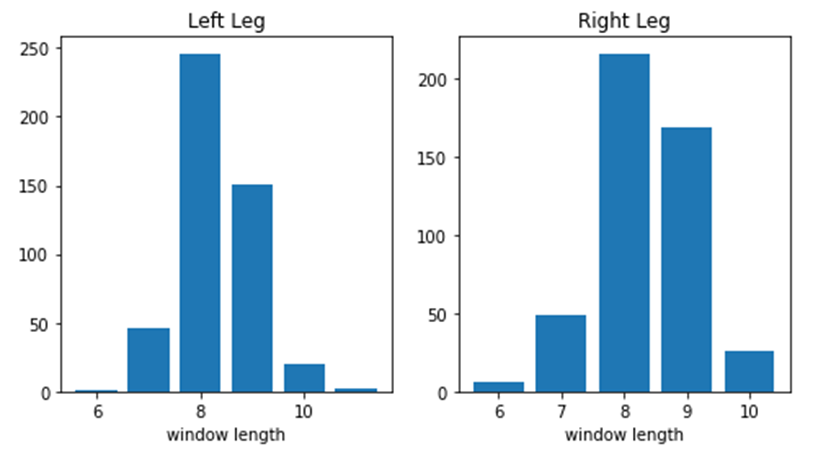

# Slicing the data into sub-series

In [ ]:
def create_samples(data, col_to_NN, win_from_left, win_from_right):
    """
    This function creates sample windows of data with specified length for step and non-step data. 
    
    Parameters:
        data (pandas DataFrame): The data to create samples from
        col_to_NN (str): The column in the data to be used in the samples
        win_from_left (int): The number of steps to take from the left of a step
        win_from_right (int): The number of steps to take from the right of a step
    
    Returns:
        step_samples (List[np.ndarray]): List of samples of step data
        none_samples (List[np.ndarray]): List of samples of non-step data
    """
    
    # Get the indices of data where the foot column is 1 or 2
    idx_1 = list(data[data['foot'] == 1].index)
    idx_2 = list(data[data['foot'] == 2].index)

    # Initialize lists to store step and non-step samples
    step_samples = []
    none_samples = []

    # Create a step sequence to compare with the data
    step_sequence = np.concatenate((np.zeros(win_from_left), np.array([1]), np.zeros(win_from_right)))

    # Loop through the indices of foot 1
    for i in idx_1:
        # Get the foot and feature data for the sample window
        step_data = data['foot'][i - win_from_left : i + win_from_right + 1]
        win_data = data[col_to_NN].iloc[i - win_from_left : i + win_from_right +1].to_numpy()
        # If the step data matches the step sequence, add the feature data to the step samples
        if (step_data == step_sequence).all:
            step_samples.append(win_data)

    # Loop through the indices of foot 2
    for i in idx_2:
        # Get the feature data for the non-step sample window
        none_win_data = data[col_to_NN].iloc[i - win_from_left : i + win_from_right +1].to_numpy()
        none_samples.append(none_win_data)
        
    # Randomly select the same number of non-step samples as the samples
    #none_samples = random.sample(none_samples, k=len(step_samples))
    
    # Print the number of step and non-step samples
    print('The dataset has:\n # left leg steps = {}.\n # none leg steps = {}.'.format(len(step_samples), len(none_samples)))

    # Return the step and non-step samples
    return step_samples, none_samples


In [ ]:
def extract_data(PedometerData, cols, feat_col, list_of_persons, win_from_left, win_from_right):

    """
    This function extracts the data from multiple files and converts the data into a format suitable for processing. 
    It reads in the data files, merges the data, and creates samples of the data. 

    Parameters:
    PedometerData (str): Path to the directory containing the data.
    cols (list): List of column names for the data.
    feat_col (list): List of feature columns used for processing.
    list_of_persons (list): List of person IDs.
    win_from_left (int): Number of samples to take from the left of the window.
    win_from_right (int): Number of samples to take from the right of the window.

    Returns:
    tuple: Tuple of two lists, one for the step samples and one for the non-step samples.
    """

    step_samples = []
    none_samples = []

    for person_idx in list_of_persons: # list_of_persons = ['01', '02', ...,'30']

      # Lists to store the paths, data, and start times for person 1
      P1_paths = []
      P1_data = []
      P1_start_time = []

      # Loop through the sensors
      for sensor in range(1, SENSORS_NUM+1):
        # Add the path to the list of paths
        P1_paths.append(path.join(PedometerData, 'P0{}'.format(person_idx), 'Regular', 'Sensor0{}.csv'.format(sensor)))
        # Read the data from the file and add it to the list of data
        P1_data.append(pd.read_csv(P1_paths[-1], sep='\t',skiprows=2).iloc[:,:-1])
        # Assign the columns to the data
        P1_data[-1].columns = cols
        # Add the start time to the list of start times
        P1_start_time.append(P1_data[-1]['Date'][0])

      # Convert the start times to seconds
      sensors_start_time = get_seconds(P1_start_time)

      # Find the index of the last sensor to report
      last_sensor_report = sensors_start_time.index(max(sensors_start_time))

      # Print the person number and the last sensor to report
      print('person #{} last sensor to report is {} sensor'.format(person_idx, last_sensor_report+1))

      # # Calculate the time in seconds for each row of data
      for sensor in range(SENSORS_NUM):
        P1_data[sensor]['Time_in_Sec'] = np.array(get_seconds(list(P1_data[sensor]['Date']))) - sensors_start_time[last_sensor_report]
        P1_data[sensor] = P1_data[sensor][P1_data[sensor]['Time_in_Sec'] >= 0]

      # Define the path to the steps data file for person 1
      P1_steps = path.join(PedometerData, 'P0{}'.format(person_idx), 'Regular', 'steps.txt')
      # Read the steps data file into a pandas data frame
      foot = pd.read_csv(P1_steps,header=None,sep=" ",names=['index','foot'])
      # Convert the text file (steps) to a new column in the data frame
      check_to_merge = P1_data[2].reset_index()

      # Merge the steps data with the main data frame on the 'index' column
      P1_data[2] = check_to_merge.merge(foot,how='left',on='index').drop('index',axis=1)
      # Apply a lambda function to convert the values in the 'foot' column
      P1_data[2]['foot'] = P1_data[2]['foot'].apply(lambda x: convert(x))
      # Show the first 5 rows of the updated data frame
      P1_data[2].head()

      # clean_data = P1_data[2][feat_col]
      # if len(list_of_persons) == 1:
      #   for col in feat_col[:-1]:
      #     clean_data[col] = clean_data[col] /clean_data[col].abs().max()

      # Create step and none-step samples from the updated data frame
      step_samples_P1, none_samples_P1 = create_samples(P1_data[2][feat_col], feat_col[:-1], win_from_left, win_from_right) #P1_data[2][feat_col]

      # Append the step and none-step samples for person 1 to the overall lists
      step_samples.append(step_samples_P1)
      none_samples.append(none_samples_P1)
  
    return list(itertools.chain(*step_samples)), list(itertools.chain(*none_samples))

In [ ]:
# Extract the data according to selected persons
list_of_persons = ['01']
win_from_left=0
win_from_right=4
step_samples, none_samples = extract_data(pedometer_data_dir, cols, feat_col, list_of_persons, win_from_left, win_from_right)

person #01 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 467.
 # none leg steps = 466.


# Data Whitening

In [ ]:
def data_whitening(arr_step, arr_none, win_len):
    """
    This function performs data whitening on the input arrays of step and none samples. It uses the StandardScaler
    from the scikit-learn library to normalize the data and then reshapes the arrays into a 2D numpy array.

    arr_step: numpy array of step samples
    arr_none: numpy array of none samples
    win_len: window length to use for reshaping the arrays

    returns: step_samples, none_samples - the normalized step and none samples divided into windows of length win_len
    """
    # Stack the two arrays vertically to create one large array of all data
    all_data = np.vstack([arr_step.reshape(win_len * arr_step.shape[0], FEATURE_NUM),
                          arr_none.reshape(win_len * arr_none.shape[0], FEATURE_NUM)])

    # Create a StandardScaler object to normalize the data
    scaler = StandardScaler()
    scaler.fit(all_data)

    # Use the StandardScaler to normalize the step and none samples
    arr_step_scaled = scaler.transform(arr_step.reshape(win_len * arr_step.shape[0], FEATURE_NUM))
    step_samples = [arr_step_scaled[i:i + win_len] for i in range(0, arr_step_scaled.shape[0], 5)]

    arr_none_scaled = scaler.transform(arr_none.reshape(win_len * arr_none.shape[0], FEATURE_NUM))
    none_samples = [arr_none_scaled[i:i + win_len] for i in range(0, arr_none_scaled.shape[0], win_len)]

    return step_samples, none_samples


In [ ]:
# Whitening the Data
win_len = win_from_left + win_from_right + 1
#scaled_step_samples, scaled_none_samples = data_whitening(np.array(step_samples), np.array(none_samples), win_len)
scaled_step_samples, scaled_none_samples = step_samples, none_samples

# Plot data distribution

In [ ]:
def plot_data_dist(arr_step, arr_none, header, ylim):
  """ The function `plot_data_dist` plots histograms of the features distribution of two classes of data. 
      It takes in 3 arguments: `arr_step`, `arr_none`, and `ylim`. 
      `arr_step` represents the data of the step class, 
      `arr_none` represents the data of the non-step class, 
      and `ylim` represents the maximum limit for the y-axis in the plots. """

  fig, axes = plt.subplots(CLASS_NUM, FEATURE_NUM, figsize=(20,10))
  # set the title of the plot
  plt.suptitle(header, fontsize=18)
  # adjust the space between the subplots
  fig.subplots_adjust(top=0.93)
  
  # set the density of the histograms to false 
  show_density = False
  # set the number of bins in the histograms
  bins_num = 500
  
  # loop through the classes of data
  for i, data_class in enumerate([arr_step, arr_none]):
      # loop through each feature
      for feature in range(FEATURE_NUM):
          # plot the histogram of the feature data
          axes[i][feature].hist(data_class[:,:,feature].reshape(-1), density=show_density, bins=bins_num)
          # set the title of the plot to the feature name and class name
          axes[i][feature].set_title('{} ({})'.format(feat_col[feature], class_names[i]))
          # set the maximum limit for the y-axis in the plots
          axes[i][feature].set_ylim([0, ylim])

    # save the plot to a file
    # fig.savefig(pedometer_data_dir + 'FeaturesDist')


# Randomly Sampling the participant group

In [ ]:
one_person = ['01']
# Extract multiple person's data
list_of_persons = random.sample(['0{}'.format(num) if num < 10 else  '{}'.format(num) for num in range(1,30)], k=8)
print('The persons which their samples were taken are:\n\t{}.\n'.format(list_of_persons))

print("One person:\n")
step_samples_one_person, none_samples_one_person = extract_data(pedometer_data_dir, cols, feat_col, one_person, win_from_left, win_from_right)
print("\nMulti person:\n")
step_samples_multi_persons, none_samples_multi_persons = extract_data(pedometer_data_dir, cols, feat_col, list_of_persons, win_from_left, win_from_right)

The person which their samples were taken are:
	['10', '25', '15', '06', '26', '08', '04', '20'].

One person:

person #01 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 467.
 # none leg steps = 466.

Multi person:

person #10 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 504.
 # none leg steps = 504.
person #25 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 471.
 # none leg steps = 471.
person #15 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 481.
 # none leg steps = 481.
person #06 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 454.
 # none leg steps = 457.
person #26 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 489.
 # none leg steps = 490.
person #08 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 517.
 # none leg steps = 512.
person #04 last sensor to report is 3 sensor
The dataset has:
 # left leg steps = 548.
 

In [ ]:
# Experiment 1: ['01', '03', '08', '10', '11', '17', '22', '30']
# Experiment 2: ['10', '25', '15', '06', '26', '08', '04', '20']
# Experiment 3: ['25', '28', '23', '04', '14', '08', '20', '24']
# Experiment 4: ['09', '19', '08', '18', '14', '06', '02', '01']
# Experiment 5: ['10', '28', '29', '23', '06', '09', '07', '21']

In [ ]:
# Whitening the Data
#step_samples, none_samples = data_whitening(np.array(step_samples), np.array(none_samples), win_len)
scaled_step_samples_one_person, scaled_none_samples_one_person = data_whitening(np.array(step_samples_one_person), np.array(none_samples_one_person), win_len)
scaled_step_samples_multi_persons, scaled_none_samples_multi_persons = data_whitening(np.array(step_samples_multi_persons), np.array(none_samples_multi_persons), win_len)
#scaled_step_samples, scaled_none_samples = step_samples, none_samples

In [ ]:
# Shuffle the data
random.shuffle(scaled_step_samples_one_person)
random.shuffle(scaled_none_samples_one_person)
random.shuffle(scaled_step_samples_multi_persons)
random.shuffle(scaled_none_samples_multi_persons)

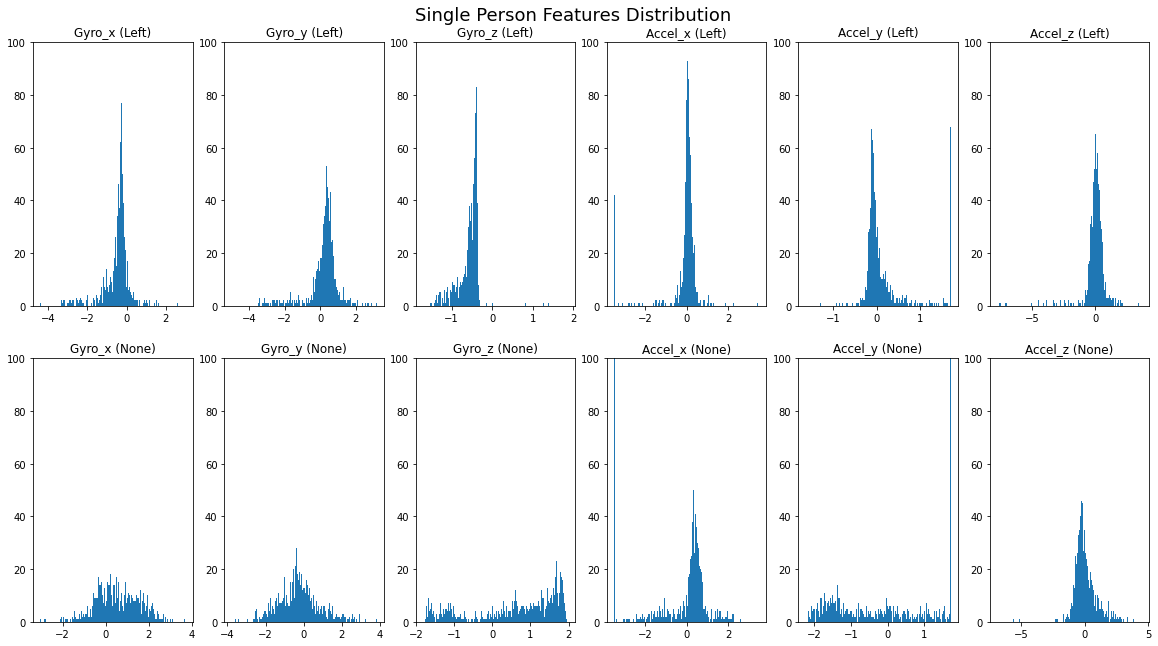

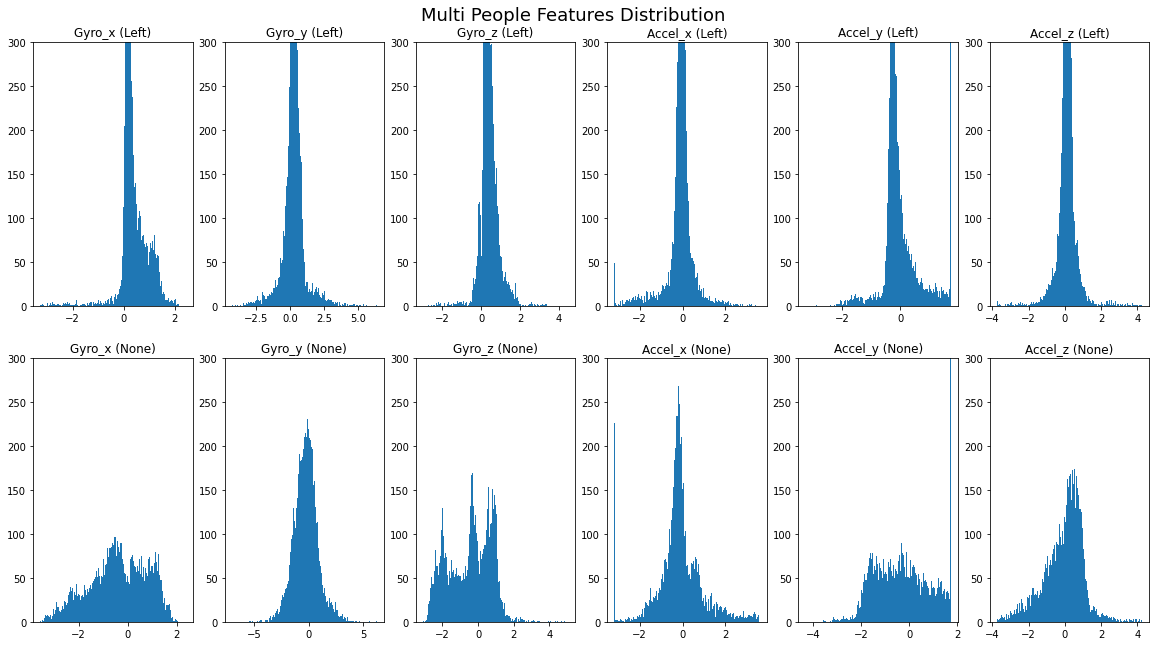

In [ ]:
# Plot the data distribution
plot_data_dist(np.array(scaled_step_samples_one_person), np.array(scaled_none_samples_one_person), 'Single Person Features Distribution', ylim=100)
plot_data_dist(np.array(scaled_step_samples_multi_persons), np.array(scaled_none_samples_multi_persons), 'Multi People Features Distribution', ylim=300)

# Spliting the data to sets (train, validation, test)

In [ ]:
# Split the data into training, validation, and test sets
train_frac, val_frac, test_frac = 0.7, 0.2, 0.1

# Define the labels for step samples and not step samples
leg_y_one_person = [[1.0, 0.0]] * len(scaled_step_samples_one_person)
none_y_one_person = [[0.0, 1.0]] * len(scaled_none_samples_one_person)

leg_y_multi_persons = [[1.0, 0.0]] * len(scaled_step_samples_multi_persons)
none_y_multi_persons = [[0.0, 1.0]] * len(scaled_none_samples_multi_persons)

# Step samples
split_idx_one_person = int(len(scaled_step_samples_one_person)*train_frac)

split_idx_multi_persons = int(len(scaled_step_samples_multi_persons)*train_frac)

# Split the step samples into training set
train_x_leg_1_one_person, remaining_x_leg_1_one_person = scaled_step_samples_one_person[:split_idx_one_person], scaled_step_samples_one_person[split_idx_one_person:]
train_y_leg_1_one_person, remaining_y_leg_1_one_person = leg_y_one_person[:split_idx_one_person], leg_y_one_person[split_idx_one_person:]

train_x_leg_1_multi_persons, remaining_x_leg_1_multi_persons = scaled_step_samples_multi_persons[:split_idx_multi_persons], scaled_step_samples_multi_persons[split_idx_multi_persons:]
train_y_leg_1_multi_persons, remaining_y_leg_1_multi_persons = leg_y_multi_persons[:split_idx_multi_persons], leg_y_multi_persons[split_idx_multi_persons:]

# Split the remaining step samples into validation set
test_idx_one_person = int(len(remaining_x_leg_1_one_person)*(val_frac/(val_frac+test_frac)))
val_x_leg_1_one_person, test_x_leg_1_one_person = remaining_x_leg_1_one_person[:test_idx_one_person], remaining_x_leg_1_one_person[test_idx_one_person:]
val_y_leg_1_one_person, test_y_leg_1_one_person = remaining_y_leg_1_one_person[:test_idx_one_person], remaining_y_leg_1_one_person[test_idx_one_person:]

test_idx_multi_persons = int(len(remaining_x_leg_1_multi_persons)*(val_frac/(val_frac+test_frac)))
val_x_leg_1_multi_persons, test_x_leg_1_multi_persons = remaining_x_leg_1_multi_persons[:test_idx_multi_persons], remaining_x_leg_1_multi_persons[test_idx_multi_persons:]
val_y_leg_1_multi_persons, test_y_leg_1_multi_persons = remaining_y_leg_1_multi_persons[:test_idx_multi_persons], remaining_y_leg_1_multi_persons[test_idx_multi_persons:]

# Not step samples
split_idx_one_person = int(len(scaled_none_samples_one_person)*train_frac)
split_idx_multi_persons = int(len(scaled_none_samples_multi_persons)*train_frac)

# Split the not step samples into training set
train_x_none_one_person, remaining_x_none_one_person = scaled_none_samples_one_person[:split_idx_one_person], scaled_none_samples_one_person[split_idx_one_person:]
train_y_none_one_person, remaining_y_none_one_person = none_y_one_person[:split_idx_one_person], none_y_one_person[split_idx_one_person:]

train_x_none_multi_persons, remaining_x_none_multi_persons = scaled_none_samples_multi_persons[:split_idx_multi_persons], scaled_none_samples_multi_persons[split_idx_multi_persons:]
train_y_none_multi_persons, remaining_y_none_multi_persons = none_y_multi_persons[:split_idx_multi_persons], none_y_multi_persons[split_idx_multi_persons:]

# Split the remaining not step samples into validation set
test_idx_one_person = int(len(remaining_x_none_one_person)*(val_frac/(val_frac+test_frac)))
val_x_none_one_person, test_x_none_one_person = remaining_x_none_one_person[:test_idx_one_person], remaining_x_none_one_person[test_idx_one_person:]
val_y_none_one_person, test_y_none_one_person = remaining_y_none_one_person[:test_idx_one_person], remaining_y_none_one_person[test_idx_one_person:]

test_idx_multi_persons = int(len(remaining_x_none_multi_persons)*(val_frac/(val_frac+test_frac)))
val_x_none_multi_persons, test_x_none_multi_persons = remaining_x_none_multi_persons[:test_idx_multi_persons], remaining_x_none_multi_persons[test_idx_multi_persons:]
val_y_none_multi_persons, test_y_none_multi_persons = remaining_y_none_multi_persons[:test_idx_multi_persons], remaining_y_none_multi_persons[test_idx_multi_persons:]

# Concatenate the split data into one training set, one validation set, and one test set
train_x_one_person = [*train_x_leg_1_one_person, *train_x_none_one_person]
train_y_one_person = [*train_y_leg_1_one_person, *train_y_none_one_person]

val_x_one_person = [*val_x_leg_1_one_person, *val_x_none_one_person]
val_y_one_person = [*val_y_leg_1_one_person, *val_y_none_one_person]

test_x_one_person = [*test_x_leg_1_one_person, *test_x_none_one_person]
test_y_one_person = [*test_y_leg_1_one_person, *test_y_none_one_person]

train_x_multi_persons = [*train_x_leg_1_multi_persons, *train_x_none_multi_persons]
train_y_multi_persons = [*train_y_leg_1_multi_persons, *train_y_none_multi_persons]

val_x_multi_persons = [*val_x_leg_1_multi_persons, *val_x_none_multi_persons]
val_y_multi_persons = [*val_y_leg_1_multi_persons, *val_y_none_multi_persons]

test_x_multi_persons = [*test_x_leg_1_multi_persons, *test_x_none_multi_persons]
test_y_multi_persons = [*test_y_leg_1_multi_persons, *test_y_none_multi_persons]
# Print the number of samples in each set
print("One Person:")
print("\t\t\tSamples:")
print("Train set: \t\t{}".format(len(train_x_one_person)), 
      "\nValidation set: \t{}".format(len(val_x_one_person)),
      "\nTest set: \t\t{}".format(len(test_x_one_person)))
print("\nMulti People:")
print("\t\t\tSamples:")
print("Train set: \t\t{}".format(len(train_x_multi_persons)), 
      "\nValidation set: \t{}".format(len(val_x_multi_persons)),
      "\nTest set: \t\t{}".format(len(test_x_multi_persons)))

One Person:
			Samples:
Train set: 		652 
Validation set: 	187 
Test set: 		94

Multi People:
			Samples:
Train set: 		5720 
Validation set: 	1636 
Test set: 		818


# Train function

In [ ]:
def train(model, n_epochs, train_dataset, validation_dataset, checkpoint_path):
  valid_loss_min = np.Inf
  loss_train_lst = []
  loss_valid_lst = []

  for epoch in range(n_epochs):

      # keep track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0

      # train the model
      model.train()
      for data, label in train_dataset:
        # print("data = {}".format(data))
        # print("label = {}".format(label))
        # Since the dataset is large, train on 'dataset_size' samples.
        if np.shape(label)[0] != batch_size:
          break
        optimizer.zero_grad()
        output = model(data.float())
        # print("output = {}".format(output))
        loss = criterion(output, label)
        # print("loss = {}".format(loss))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
      
      # validate the model 
      model.eval()
      for data, label in validation_dataset:
        if np.shape(label)[0] != batch_size:
          break
        output = model(data.float())
        loss = criterion(output, label)
        valid_loss += loss.item()*data.size(0)
      
      # calculate average losses
      train_loss = train_loss/len(train_dataset)
      valid_loss = valid_loss/len(validation_dataset)
      
      # print training/validation statistics 
      print('Epoch {}: \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      loss_train_lst.append(train_loss)
      loss_valid_lst.append(valid_loss)
      scheduler.step()
      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), checkpoint_path)
          valid_loss_min = valid_loss
          
  return loss_train_lst, loss_valid_lst

# CNN architecture

In [ ]:
import torch.nn as nn

class StepNet_CNN(nn.Module):
  def __init__(self, NN_params):
    super(StepNet_CNN, self).__init__()

    # Neural Network
    self.params = NN_params
    
    # CNN Layer
    self.CNN1D = nn.Conv1d(self.params['CNN1D']['input_dim'], self.params['CNN1D']['output_dim'], kernel_size = 3, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

    # Fully-Connected Layers
    self.fc1 = nn.Linear(self.params['fc1']['input_dim'], self.params['fc1']['output_dim'])
    self.fc2 = nn.Linear(self.params['fc2']['input_dim'], self.params['fc2']['output_dim'])
    self.fc3 = nn.Linear(self.params['fc3']['input_dim'], self.params['fc3']['output_dim'])

    # Activations
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()
    
  # Forward Pass
  def forward(self, x):
    x = torch.permute(x, (0, 2, 1)) # Arrange the size to be (batch, IMU, time) instead of (batch, time, IMU)
    x = self.CNN1D(x)
    x = x.flatten(start_dim=1) # Dont Flatten the batch
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    return x

In [ ]:
StepNet_CNN_params = dict(CNN1D = dict(input_dim = FEATURE_NUM, output_dim = 32),
                      fc1 = dict(input_dim = 96, output_dim = 32 ),
                      fc2 = dict(input_dim = 32, output_dim = 8  ),
                      fc3 = dict(input_dim = 8, output_dim = CLASS_NUM))

model = StepNet_CNN(StepNet_CNN_params)
print(model)

StepNet_CNN(
  (CNN1D): Conv1d(6, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=96, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)


# CNN



## One pesron

### One person (CNN): Create data loader and train the network

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data_one_person = TensorDataset(torch.from_numpy(np.array(train_x_one_person)), torch.from_numpy(np.array(train_y_one_person)))
valid_data_one_person = TensorDataset(torch.from_numpy(np.array(val_x_one_person)), torch.from_numpy(np.array(val_y_one_person)))
test_data_one_person = TensorDataset(torch.from_numpy(np.array(test_x_one_person)), torch.from_numpy(np.array(test_y_one_person)))

batch_size = 32

train_loader_one_person = DataLoader(train_data_one_person, shuffle=True, batch_size=batch_size)
valid_loader_one_person = DataLoader(valid_data_one_person, shuffle=True, batch_size=batch_size)
test_loader_one_person = DataLoader(test_data_one_person, shuffle=True, batch_size=1) #len(test_y)

network parameters

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR

model_CNN_one_person = StepNet_CNN(StepNet_CNN_params)
checkpoint_path = '/content/gdrive/Shareddrives/Intro2Deep/final_project/GRU_based_solution/checkpoints/CNN_one_person.pk'
#model_CNN_one_person.load_state_dict(torch.load(checkpoint_path))

# loss function and optimizer
learning_rate =8e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN_one_person.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

# number of epochs to train the model
n_epochs = 50

loss_train_lst_one_person, loss_valid_lst_one_person = train(model_CNN_one_person, n_epochs, train_loader_one_person, valid_loader_one_person, checkpoint_path)

Epoch 0: 	Training Loss: 13.536595 	Validation Loss: 0.366268
Validation loss decreased (inf --> 0.366268).  Saving model ...
Epoch 1: 	Training Loss: 11.402465 	Validation Loss: 5.767929
Epoch 2: 	Training Loss: 0.758280 	Validation Loss: 0.000000
Validation loss decreased (0.366268 --> 0.000000).  Saving model ...
Epoch 3: 	Training Loss: 34.743066 	Validation Loss: 20.142728
Epoch 4: 	Training Loss: 3.723540 	Validation Loss: 0.000004
Epoch 5: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 6: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 7: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 8: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 9: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 10: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 11: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 12: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch 13: 	Training Loss: 0.000000 	Validation Loss: 0.000002
Epoch

### One pesron (CNN): learning curves

In [ ]:
def plot_learn_curves(loss_train_lst, loss_valid_lst, scn_title, xlim=None, ylim=None):
  plt.figure(figsize=(8,8))
  plt.plot(loss_train_lst, label='Train Loss')
  plt.plot(loss_valid_lst, label='Valid Loss')
  plt.legend()
  plt.title('Train & Valid Loss ({})'.format(scn_title))
  plt.xlabel('Epoches')
  plt.ylabel('Loss')
  if xlim is  None or ylim is not None:
    plt.xlim([0,xlim])
    plt.ylim([0,ylim])

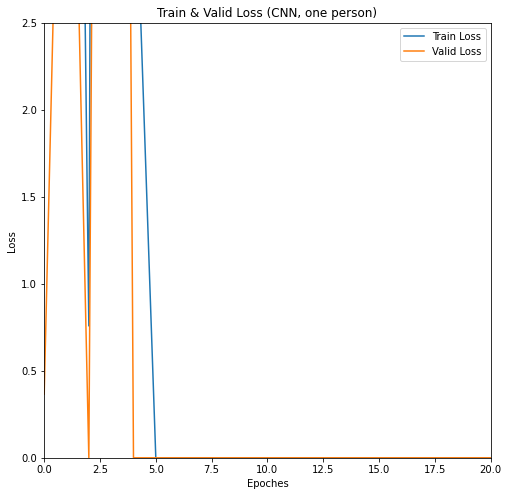

In [ ]:
scn_title = 'CNN, one person'
plot_learn_curves(loss_train_lst_one_person, loss_valid_lst_one_person, scn_title, xlim=20, ylim=2.5)

### One person (CNN): model evaluation

In [ ]:
model_CNN_one_person.eval()
#model_CNN_one_person.load_state_dict(torch.load(checkpoint_path))
acc = 0.0
loss = 0.0
for data, label in test_loader_one_person:
  output = model_CNN_one_person(data.float())
  loss += criterion(output, label).item()
  pred_class = torch.argmax(nn.functional.softmax(output,dim=1)).item()
  true_class = torch.argmax(label).item()
  if pred_class is true_class:
    acc += 1

print(loss/len(test_loader_one_person))
print(100*acc/len(test_loader_one_person))

0.0
100.0


### One person (CNN): t- SNE representation

In [ ]:
def display_tSNE(data_loader, model):
  representaed_GRU_lst = []
  representaed_GRU_label_lst = []
  for data, label in data_loader:
    output = model(data.float())
    representaed_GRU_lst.append(output.detach().squeeze(dim=0).numpy())
    representaed_GRU_label_lst.append(label)

  n_components = 2
  tsne = TSNE(n_components)
  tsne_result = tsne.fit_transform(np.array(representaed_GRU_lst))

  step_tsne = []
  none_tsne = []
  for idx, label in enumerate(representaed_GRU_label_lst):
    true_class = torch.argmax(label).item()
    if true_class==0:
      step_tsne.append(tsne_result[idx,:])
    else:
      none_tsne.append(tsne_result[idx,:])

  step_arr= np.array(step_tsne)
  none_arr= np.array(none_tsne)

  plt.figure(figsize=(8,8))
  plt.scatter(step_arr[:,0], step_arr[:,1], color='blue', label='step')
  plt.scatter(none_arr[:,0], none_arr[:,1], color='red', label='not step')
  plt.title('t- SNE Representation of Output')
  plt.xlabel('t-SNE 1')
  plt.ylabel('t-SNE 2')
  plt.legend()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



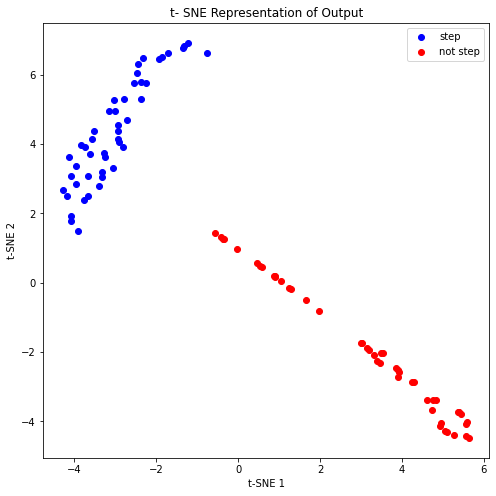

In [ ]:
display_tSNE(test_loader_one_person, model_CNN_one_person)

## Multi people

### Multi people (CNN): Create data loader and train the network

In [ ]:
# create Tensor datasets
train_data_multi_persons = TensorDataset(torch.from_numpy(np.array(train_x_multi_persons)), torch.from_numpy(np.array(train_y_multi_persons)))
valid_data_multi_persons = TensorDataset(torch.from_numpy(np.array(val_x_multi_persons)), torch.from_numpy(np.array(val_y_multi_persons)))
test_data_multi_persons = TensorDataset(torch.from_numpy(np.array(test_x_multi_persons)), torch.from_numpy(np.array(test_y_multi_persons)))

batch_size = 256

train_loader_multi_persons = DataLoader(train_data_multi_persons, shuffle=True, batch_size=batch_size)
valid_loader_multi_persons = DataLoader(valid_data_multi_persons, shuffle=True, batch_size=batch_size)
test_loader_multi_persons = DataLoader(test_data_multi_persons, shuffle=True, batch_size=1) #len(test_y)

In [ ]:
from torch.optim.lr_scheduler import ExponentialLR
model_CNN_multi_persons = StepNet_CNN(StepNet_CNN_params)
checkpoint_path = '/content/gdrive/Shareddrives/Intro2Deep/final_project/GRU_based_solution/checkpoints/CNN_multi_persons.pk'
#model_CNN_multi_persons.load_state_dict(torch.load(checkpoint_path))

# number of epochs to train the model
n_epochs = 50

# loss function and optimizer
learning_rate =5e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_CNN_multi_persons.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.9)

loss_train_lst_multi_persons, loss_valid_lst_multi_persons = train(model_CNN_multi_persons, n_epochs, train_loader_multi_persons, valid_loader_multi_persons, checkpoint_path)

Epoch 0: 	Training Loss: 100.650431 	Validation Loss: 48.326120
Validation loss decreased (inf --> 48.326120).  Saving model ...
Epoch 1: 	Training Loss: 43.602219 	Validation Loss: 32.349210
Validation loss decreased (48.326120 --> 32.349210).  Saving model ...
Epoch 2: 	Training Loss: 32.370699 	Validation Loss: 24.826577
Validation loss decreased (32.349210 --> 24.826577).  Saving model ...
Epoch 3: 	Training Loss: 27.840943 	Validation Loss: 22.935777
Validation loss decreased (24.826577 --> 22.935777).  Saving model ...
Epoch 4: 	Training Loss: 24.150559 	Validation Loss: 19.380854
Validation loss decreased (22.935777 --> 19.380854).  Saving model ...
Epoch 5: 	Training Loss: 21.457681 	Validation Loss: 18.586373
Validation loss decreased (19.380854 --> 18.586373).  Saving model ...
Epoch 6: 	Training Loss: 19.244793 	Validation Loss: 16.240233
Validation loss decreased (18.586373 --> 16.240233).  Saving model ...
Epoch 7: 	Training Loss: 17.558623 	Validation Loss: 16.574848
Epoc

### Multi people (CNN): learning curves

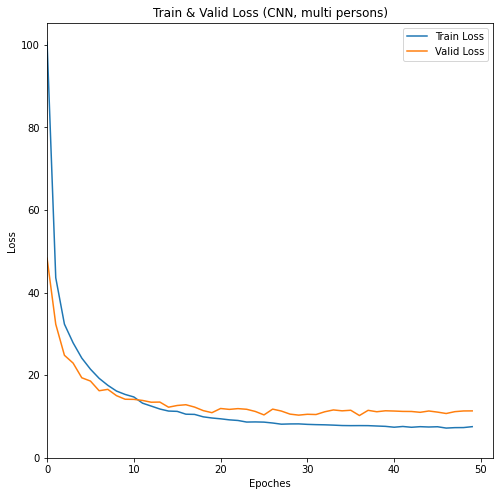

In [ ]:
scn_title = 'CNN, multi persons'
plot_learn_curves(loss_train_lst_multi_persons, loss_valid_lst_multi_persons, scn_title)

### Multi people (CNN): model evaluation

In [ ]:
model_CNN_multi_persons.eval()
#model_CNN_multi_persons.load_state_dict(torch.load(checkpoint_path))
acc = 0.0
loss = 0.0
for data, label in test_loader_multi_persons:
  output = model_CNN_multi_persons(data.float())
  loss += criterion(output, label).item()
  pred_class = torch.argmax(nn.functional.softmax(output,dim=1)).item()
  true_class = torch.argmax(label).item()
  if pred_class is true_class:
    acc += 1

print(loss/len(test_loader_multi_persons))
print(100*acc/len(test_loader_multi_persons))

0.04468648610088903
98.77750611246944


### Multi people (CNN): t- SNE representation

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



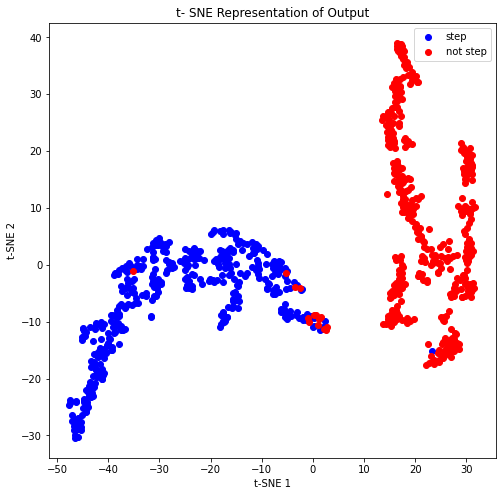

In [ ]:
display_tSNE(test_loader_multi_persons, model_CNN_multi_persons)

# GRU architecture

In [ ]:
import torch.nn as nn

class StepNet_GRU(nn.Module):
  def __init__(self, NN_params):
    super(StepNet_GRU, self).__init__()

    # Neural Network
    self.params = StepNet_params
  
    # GRU Layer
    self.GRU = nn.GRU(self.params['GRU']['input_dim'], self.params['GRU']['hidden_dim'], batch_first =True)

    # Combined Fully-Connected Layers
    self.fc1 = nn.Linear(self.params['fc1']['input_dim'], self.params['fc1']['output_dim'])
    self.fc2 = nn.Linear(self.params['fc2']['input_dim'], self.params['fc2']['output_dim'])
    self.fc3 = nn.Linear(self.params['fc3']['input_dim'], self.params['fc3']['output_dim'])

    # Activations
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):

    #x_out, h_n = self.GRU1(x)
    x_out, h_n = self.GRU(x) #x_out

    x_out = self.tanh(self.fc1(x_out[:,-1,:]))
    x_out = self.tanh(self.fc2(x_out))
    x_out = self.fc3(x_out)

    return x_out

In [ ]:
StepNet_params = dict(GRU = dict(input_dim = FEATURE_NUM, hidden_dim = 128),
                      fc1 = dict(input_dim = 128, output_dim = 64),
                      fc2 = dict(input_dim = 64, output_dim = 16),
                      fc3 = dict(input_dim = 16, output_dim = CLASS_NUM ))

# GRU

## One person

### One person (GRU): Create data loader and train the network

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# create Tensor datasets
train_data_one_person = TensorDataset(torch.from_numpy(np.array(train_x_one_person)), torch.from_numpy(np.array(train_y_one_person)))
valid_data_one_person = TensorDataset(torch.from_numpy(np.array(val_x_one_person)), torch.from_numpy(np.array(val_y_one_person)))
test_data_one_person = TensorDataset(torch.from_numpy(np.array(test_x_one_person)), torch.from_numpy(np.array(test_y_one_person)))

batch_size = 8

train_loader_one_person = DataLoader(train_data_one_person, shuffle=True, batch_size=batch_size)
valid_loader_one_person = DataLoader(valid_data_one_person, shuffle=True, batch_size=batch_size)
test_loader_one_person = DataLoader(test_data_one_person, shuffle=True, batch_size=1) #len(test_y)

In [ ]:
model_GRU_one_person = StepNet_GRU(StepNet_params)
checkpoint_path = '/content/gdrive/Shareddrives/Intro2Deep/final_project/GRU_based_solution/checkpoints/GRU_one_person.pk'
model_GRU_one_person.load_state_dict(torch.load(checkpoint_path))

# loss function and optimizer
learning_rate = 5e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_GRU_one_person.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.9)

# number of epochs to train the model
n_epochs = 20

loss_train_lst_one_person, loss_valid_lst_one_person = train(model_GRU_one_person, n_epochs, train_loader_one_person, valid_loader_one_person, checkpoint_path)

Epoch 0: 	Training Loss: 2.687940 	Validation Loss: 0.095316
Validation loss decreased (inf --> 0.095316).  Saving model ...
Epoch 1: 	Training Loss: 0.295508 	Validation Loss: 0.026021
Validation loss decreased (0.095316 --> 0.026021).  Saving model ...
Epoch 2: 	Training Loss: 0.302341 	Validation Loss: 0.275602
Epoch 3: 	Training Loss: 0.253948 	Validation Loss: 0.674579
Epoch 4: 	Training Loss: 0.197370 	Validation Loss: 0.252566
Epoch 5: 	Training Loss: 0.103038 	Validation Loss: 0.177936
Epoch 6: 	Training Loss: 0.183342 	Validation Loss: 0.076298
Epoch 7: 	Training Loss: 0.177622 	Validation Loss: 0.297698
Epoch 8: 	Training Loss: 0.827092 	Validation Loss: 0.961903
Epoch 9: 	Training Loss: 0.662323 	Validation Loss: 0.265881
Epoch 10: 	Training Loss: 0.231390 	Validation Loss: 0.249917
Epoch 11: 	Training Loss: 0.184491 	Validation Loss: 0.016307
Validation loss decreased (0.026021 --> 0.016307).  Saving model ...
Epoch 12: 	Training Loss: 0.059884 	Validation Loss: 0.017048
Ep

### One person (GRU): learning curves

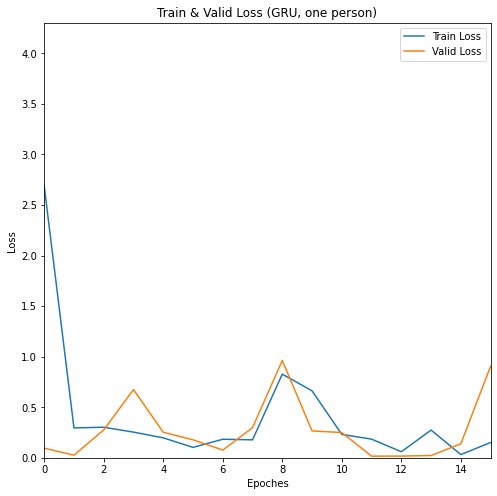

In [ ]:
scn_title = 'GRU, one person'
plot_learn_curves(loss_train_lst_one_person, loss_valid_lst_one_person, scn_title, xlim=15, ylim=4.3)

### One person (GRU): model evaluation

In [ ]:
model_GRU_one_person.eval()
#model_GRU_one_person.load_state_dict(torch.load(checkpoint_path))
acc = 0.0
loss = 0.0
for data, label in test_loader_one_person:
  output = model_GRU_one_person(data.float())
  loss += criterion(output, label).item()
  pred_class = torch.argmax(nn.functional.softmax(output,dim=1)).item()
  true_class = torch.argmax(label).item()
  if pred_class is true_class:
    acc += 1

print(loss/len(test_loader_one_person))
print(100*acc/len(test_loader_one_person))

0.0012204018675355597
100.0


### One person (GRU): t-SNE representation

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



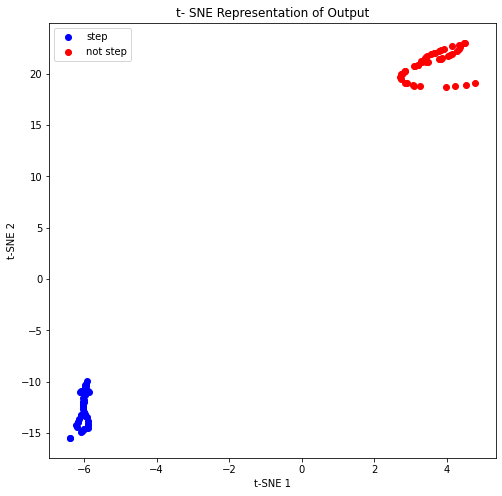

In [ ]:
display_tSNE(test_loader_one_person, model_GRU_one_person)

## Multi people

### Multi people (GRU): Create data loader and train the network

In [ ]:
# create Tensor datasets
train_data_multi_persons = TensorDataset(torch.from_numpy(np.array(train_x_multi_persons)), torch.from_numpy(np.array(train_y_multi_persons)))
valid_data_multi_persons = TensorDataset(torch.from_numpy(np.array(val_x_multi_persons)), torch.from_numpy(np.array(val_y_multi_persons)))
test_data_multi_persons = TensorDataset(torch.from_numpy(np.array(test_x_multi_persons)), torch.from_numpy(np.array(test_y_multi_persons)))

batch_size = 64

train_loader_multi_persons = DataLoader(train_data_multi_persons, shuffle=True, batch_size=batch_size)
valid_loader_multi_persons = DataLoader(valid_data_multi_persons, shuffle=True, batch_size=batch_size)
test_loader_multi_persons = DataLoader(test_data_multi_persons, shuffle=True, batch_size=1) #len(test_y_multi_persons)

In [ ]:
model_GRU_multi_persons = StepNet_GRU(StepNet_params)
checkpoint_path = '/content/gdrive/Shareddrives/Intro2Deep/final_project/GRU_based_solution/checkpoints/GRU_one_person.pk'
#model_GRU_multi_persons.load_state_dict(torch.load(checkpoint_path))

# loss function and optimizer
learning_rate = 8e-2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_GRU_multi_persons.parameters(), lr=learning_rate, weight_decay=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.8)

# number of epochs to train the model
n_epochs = 50

loss_train_lst_multi_persons, loss_valid_lst_multi_persons = train(model_GRU_multi_persons, n_epochs, train_loader_multi_persons, valid_loader_multi_persons, checkpoint_path)
# works well (8 persons)
# n_epochs = 100
# learning_rate = 4e-2
# batch_size = 16
# weight_decay=1e-3
# gamma=0.9

Epoch 0: 	Training Loss: 21.089975 	Validation Loss: 11.558543
Validation loss decreased (inf --> 11.558543).  Saving model ...
Epoch 1: 	Training Loss: 16.370268 	Validation Loss: 13.538282
Epoch 2: 	Training Loss: 14.463215 	Validation Loss: 11.111467
Validation loss decreased (11.558543 --> 11.111467).  Saving model ...
Epoch 3: 	Training Loss: 13.724821 	Validation Loss: 10.482762
Validation loss decreased (11.111467 --> 10.482762).  Saving model ...
Epoch 4: 	Training Loss: 10.334253 	Validation Loss: 10.248854
Validation loss decreased (10.482762 --> 10.248854).  Saving model ...
Epoch 5: 	Training Loss: 8.776015 	Validation Loss: 3.769965
Validation loss decreased (10.248854 --> 3.769965).  Saving model ...
Epoch 6: 	Training Loss: 6.546914 	Validation Loss: 5.657534
Epoch 7: 	Training Loss: 4.641791 	Validation Loss: 4.695373
Epoch 8: 	Training Loss: 4.319764 	Validation Loss: 3.582504
Validation loss decreased (3.769965 --> 3.582504).  Saving model ...
Epoch 9: 	Training Loss:

### Multi people (GRU): learning curves

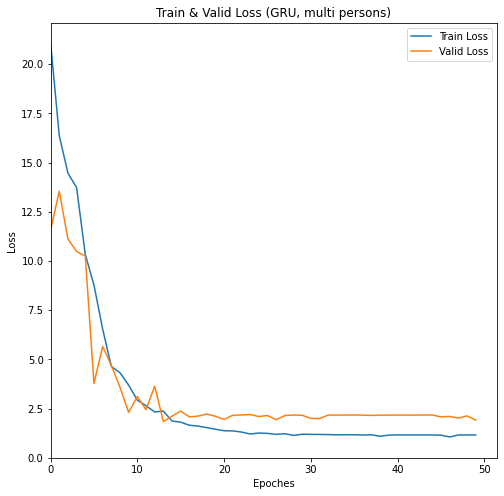

In [ ]:
scn_title = 'GRU, multi persons'
plot_learn_curves(loss_train_lst_multi_persons, loss_valid_lst_multi_persons, scn_title )

### Multi people (GRU): model evaluation

In [ ]:
model_GRU_multi_persons.eval()
#model_GRU_multi_persons.load_state_dict(torch.load(checkpoint_path))
acc = 0.0
loss = 0.0
for data, label in test_loader_multi_persons:
  output = model_GRU_multi_persons(data.float())
  loss += criterion(output, label).item()
  pred_class = torch.argmax(nn.functional.softmax(output,dim=1)).item()
  true_class = torch.argmax(label).item()
  if pred_class is true_class:
    acc += 1

print(loss/len(test_loader_multi_persons ))
print(100*acc/len(test_loader_multi_persons ))

0.02014608369885234
99.38875305623472


### Multi people (GRU): t-SNE representation

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



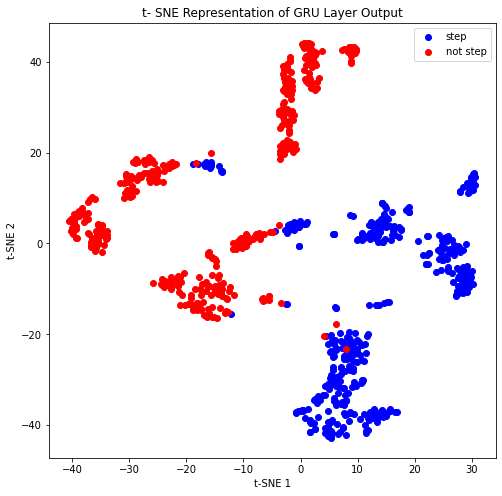

In [ ]:
representaed_GRU_lst = []
representaed_GRU_label_lst = []
for data, label in test_loader_multi_persons:
  output_GRU, _ = model_GRU_multi_persons.GRU(data.float())
  output_GRU =  output_GRU[:,-1,:]
  output_FC1 = model_GRU_multi_persons.tanh(model_GRU_multi_persons.fc1(output_GRU))
  output_FC2 = model_GRU_multi_persons.tanh(model_GRU_multi_persons.fc2(output_FC1))
  representaed_GRU_lst.append(output_GRU.detach().squeeze(dim=0).numpy())
  representaed_GRU_label_lst.append(label)

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(np.array(representaed_GRU_lst))

step_tsne = []
none_tsne = []
for idx, label in enumerate(representaed_GRU_label_lst):
  true_class = torch.argmax(label).item()
  if true_class==0:
    step_tsne.append(tsne_result[idx,:])
  else:
    none_tsne.append(tsne_result[idx,:])

step_arr= np.array(step_tsne)
none_arr= np.array(none_tsne)

plt.figure(figsize=(8,8))
plt.scatter(step_arr[:,0], step_arr[:,1], color='blue', label='step')
plt.scatter(none_arr[:,0], none_arr[:,1], color='red', label='not step')
plt.title('t- SNE Representation of GRU Layer Output')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



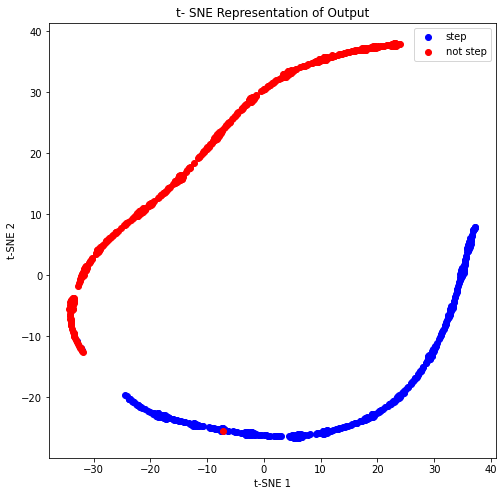

In [ ]:
display_tSNE(test_loader_multi_persons, model_GRU_multi_persons)